 # Diagnosing CPCN

In [1]:
from types import SimpleNamespace
import pydove as dv
import matplotlib as mpl

import torch

from tqdm.notebook import tqdm

from cpcn import LinearCPCNetwork, load_mnist, Trainer

 ## Setup

In [2]:
device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# this creates the loaders
batch_size = 100
dataset = load_mnist(
    n_train=5000, n_validation=1000, batch_size=batch_size, device=device
)

 ## Train PCN

In [3]:
n_epochs = 100
dims = [784, 5, 10]

z_it = 100
z_lr = 0.02

torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * torch.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * torch.ones(len(dims) - 2)
g_b[0] *= 2

net = LinearCPCNetwork(dims, z_lr=z_lr, z_it=z_it, g_a=g_a, g_b=g_b, c_m=0, l_s=g_b)
net = net.to(device)

trainer = Trainer(net, dataset["train"], dataset["validation"])
trainer.set_classifier("linear")

trainer.peek_epoch("weight", ["W_a", "W_b", "Q", "M"])
trainer.peek_sample("latent", ["z"])
trainer.peek_fast_dynamics(
    "fast",
    ["a", "b", "z", "n"],
    condition=lambda epoch, batch: epoch % 5 == 4 and batch == 49,
)

results = trainer.run(n_epochs, progress=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

 ## Check convergence of latent variables

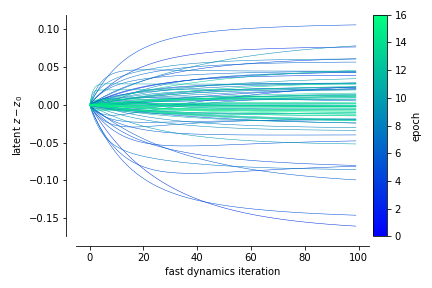

In [4]:
with dv.FigureManager() as (_, ax):
    cmap = mpl.cm.winter
    crt_sel = (trainer.history.fast["sample"] == batch_size - 1) & (
        trainer.history.fast["epoch"] < 80
    )

    crt_epoch = trainer.history.fast["epoch"][crt_sel]
    crt_z = trainer.history.fast["z:1"][crt_sel]

    n = len(crt_epoch)
    for i in range(n):
        color = cmap(int(cmap.N * (0.2 + 0.8 * i / n)))
        ax.plot(crt_z[i, :, :] - crt_z[i, 0, :], c=color, lw=0.5)

    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.pyplot.Normalize(vmin=0, vmax=n))
    sm.ax = ax
    cbar = dv.colorbar(sm)
    cbar.set_label("epoch")

    ax.set_xlabel("fast dynamics iteration")
    ax.set_ylabel("latent $z - z_0$")

 ## Check whitening constraint in hidden layer

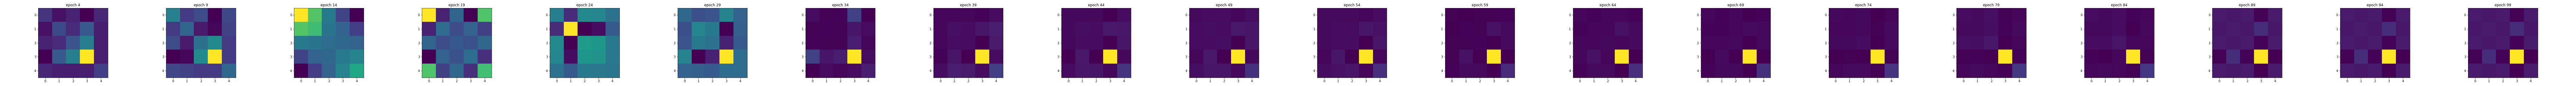

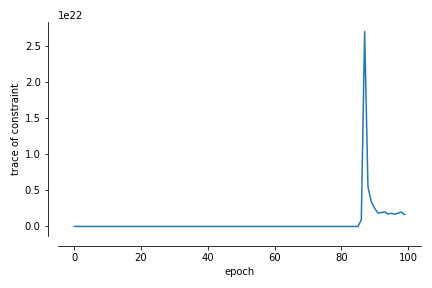

In [5]:
hidden_size = net.pyr_dims[1]
z_cov = torch.zeros((n_epochs, hidden_size, hidden_size))
for epoch in range(n_epochs):
    crt_sel = trainer.history.latent["epoch"] == epoch
    crt_z = trainer.history.latent["z:1"][crt_sel]

    z_cov[epoch] = crt_z.T @ crt_z

tr_cons = [torch.trace(z_cov[i] - torch.eye(hidden_size)) for i in range(n_epochs)]
sel_epochs = [_ for _ in range(4, n_epochs, 5)]
with dv.FigureManager(1, len(sel_epochs), do_despine=False) as (_, axs):
    for ax, epoch in zip(axs, sel_epochs):
        ax.imshow(z_cov[epoch])
        ax.set_title(f"epoch {epoch}")

with dv.FigureManager() as (_, ax):
    ax.plot(tr_cons)
    ax.set_xlabel("epoch")
    ax.set_ylabel("trace of constraint")

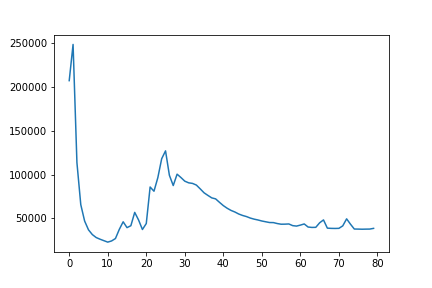

In [6]:
mpl.pyplot.plot(tr_cons[:80])

In [7]:
trainer.latent["z:1"].shape

AttributeError: 'Trainer' object has no attribute 'latent'

In [8]:
trainer.history.latent["z:1"].shape

torch.Size([500000, 5])

In [9]:
trainer.history.latent["z:1"][250_000]

tensor([ 0.0876, -0.2929, -0.1234, -2.7468, -0.6504])

In [10]:
trainer.history.weight["Q:0"][50]

tensor([[-2.5824e-03,  8.4159e-01, -5.1360e-01, -3.4282e+00, -1.8051e-01],
        [ 3.6515e-01, -4.6426e-01, -2.6090e-01,  2.0185e+00,  2.2371e-01],
        [-2.3404e-03, -9.2725e-01,  2.3403e-01,  2.0434e+00, -5.4531e-02],
        [ 3.2801e-01,  5.0090e-01, -3.4435e-01,  1.9577e+00, -2.4749e-01],
        [-4.6120e-01,  3.3799e-01, -1.9596e-01,  2.4197e+00, -3.2461e-03]])

In [11]:
crt_z.shape

torch.Size([5000, 5])

 ## Check whitening constraint in hidden layer

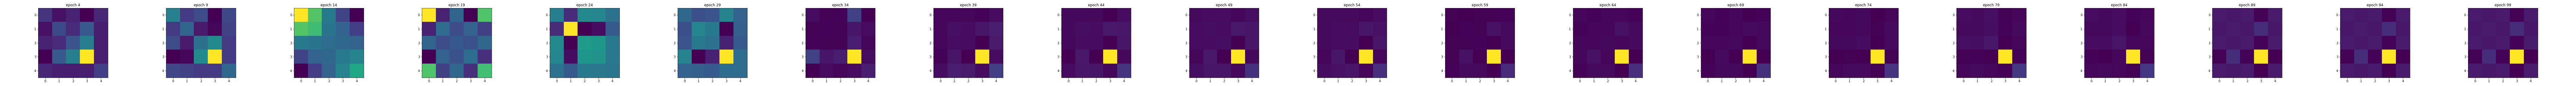

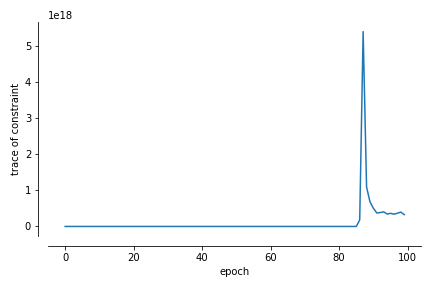

In [12]:
hidden_size = net.pyr_dims[1]
z_cov = torch.zeros((n_epochs, hidden_size, hidden_size))
for epoch in range(n_epochs):
    crt_sel = trainer.history.latent["epoch"] == epoch
    crt_z = trainer.history.latent["z:1"][crt_sel]

    z_cov[epoch] = crt_z.T @ crt_z / len(crt_z)

tr_cons = [torch.trace(z_cov[i] - torch.eye(hidden_size)) for i in range(n_epochs)]
sel_epochs = [_ for _ in range(4, n_epochs, 5)]
with dv.FigureManager(1, len(sel_epochs), do_despine=False) as (_, axs):
    for ax, epoch in zip(axs, sel_epochs):
        ax.imshow(z_cov[epoch])
        ax.set_title(f"epoch {epoch}")

with dv.FigureManager() as (_, ax):
    ax.plot(tr_cons)
    ax.set_xlabel("epoch")
    ax.set_ylabel("trace of constraint")

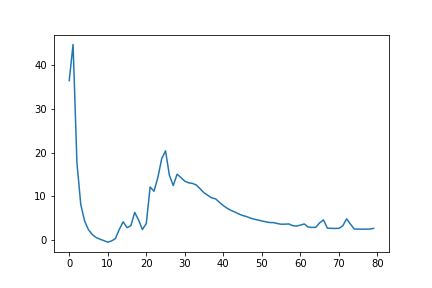

In [13]:
mpl.pyplot.plot(tr_cons[:80])

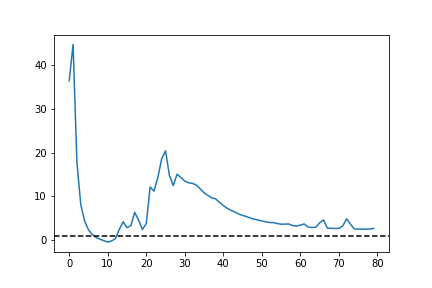

In [14]:
mpl.pyplot.plot(tr_cons[:80]); mpl.pyplot.axhline(1.0, c="k", ls="--")

 # Diagnosing CPCN

In [1]:
from types import SimpleNamespace
import pydove as dv
import matplotlib as mpl

import torch

from tqdm.notebook import tqdm

from cpcn import LinearCPCNetwork, load_mnist, Trainer

 ## Setup

In [2]:
device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# this creates the loaders
batch_size = 100
dataset = load_mnist(
    n_train=5000, n_validation=1000, batch_size=batch_size, device=device
)

 ## Train CPCN

In [3]:
n_epochs = 100
dims = [784, 5, 10]

z_it = 100
z_lr = 0.02

torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * torch.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * torch.ones(len(dims) - 2)
g_b[0] *= 2

net = LinearCPCNetwork(dims, z_lr=z_lr, z_it=z_it, g_a=g_a, g_b=g_b, c_m=0, l_s=g_b)
net = net.to(device)

trainer = Trainer(net, dataset["train"], dataset["validation"])
trainer.set_classifier("linear")

trainer.peek_epoch("weight", ["W_a", "W_b", "Q", "M"])
trainer.peek_sample("latent", ["z"])
trainer.peek_fast_dynamics(
    "fast",
    ["a", "b", "z", "n"],
    condition=lambda epoch, batch: epoch % 5 == 4 and batch == 49,
)

results = trainer.run(n_epochs, progress=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

 # Diagnosing CPCN

In [1]:
from types import SimpleNamespace
import pydove as dv
import matplotlib as mpl

import torch

from tqdm.notebook import tqdm

from cpcn import LinearCPCNetwork, load_mnist, Trainer

 ## Setup

In [2]:
device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# this creates the loaders
batch_size = 100
dataset = load_mnist(
    n_train=5000, n_validation=1000, batch_size=batch_size, device=device
)

 ## Train CPCN

In [3]:
n_epochs = 100
dims = [784, 5, 10]

z_it = 100
z_lr = 0.02

torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * torch.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * torch.ones(len(dims) - 2)
g_b[0] *= 2

net = LinearCPCNetwork(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    fast_optimizer=torch.optim.Adam,
)
net = net.to(device)

trainer = Trainer(net, dataset["train"], dataset["validation"])
trainer.set_classifier("linear")

trainer.peek_epoch("weight", ["W_a", "W_b", "Q", "M"])
trainer.peek_sample("latent", ["z"])
trainer.peek_fast_dynamics(
    "fast",
    ["a", "b", "z", "n"],
    condition=lambda epoch, batch: epoch % 5 == 4 and batch == 49,
)

results = trainer.run(n_epochs, progress=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

 ## Check convergence of latent variables

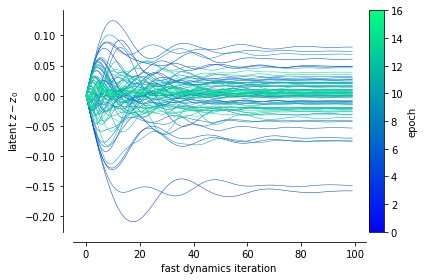

In [4]:
with dv.FigureManager() as (_, ax):
    cmap = mpl.cm.winter
    crt_sel = (trainer.history.fast["sample"] == batch_size - 1) & (
        trainer.history.fast["epoch"] < 80
    )

    crt_epoch = trainer.history.fast["epoch"][crt_sel]
    crt_z = trainer.history.fast["z:1"][crt_sel]

    n = len(crt_epoch)
    for i in range(n):
        color = cmap(int(cmap.N * (0.2 + 0.8 * i / n)))
        ax.plot(crt_z[i, :, :] - crt_z[i, 0, :], c=color, lw=0.5)

    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.pyplot.Normalize(vmin=0, vmax=n))
    sm.ax = ax
    cbar = dv.colorbar(sm)
    cbar.set_label("epoch")

    ax.set_xlabel("fast dynamics iteration")
    ax.set_ylabel("latent $z - z_0$")

 ## Check whitening constraint in hidden layer

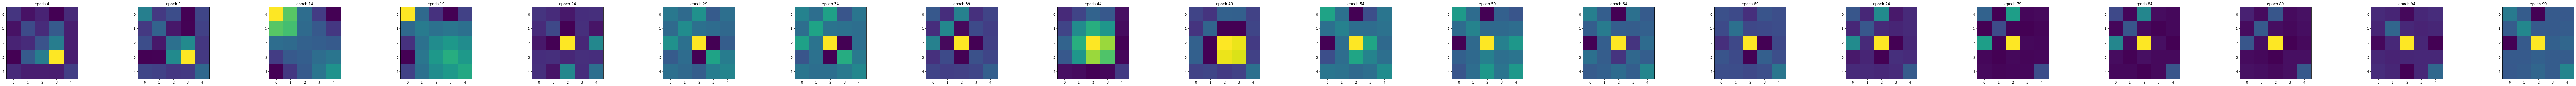

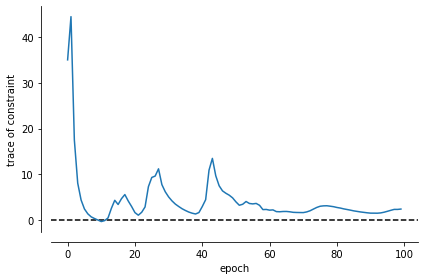

In [6]:
hidden_size = net.pyr_dims[1]
z_cov = torch.zeros((n_epochs, hidden_size, hidden_size))
for epoch in range(n_epochs):
    crt_sel = trainer.history.latent["epoch"] == epoch
    crt_z = trainer.history.latent["z:1"][crt_sel]

    z_cov[epoch] = crt_z.T @ crt_z / len(crt_z)

tr_cons = [torch.trace(z_cov[i] - torch.eye(hidden_size)) for i in range(n_epochs)]
sel_epochs = [_ for _ in range(4, n_epochs, 5)]
with dv.FigureManager(1, len(sel_epochs), do_despine=False) as (_, axs):
    for ax, epoch in zip(axs, sel_epochs):
        ax.imshow(z_cov[epoch])
        ax.set_title(f"epoch {epoch}")

with dv.FigureManager() as (_, ax):
    ax.axhline(0, c="k", ls="--")
    ax.plot(tr_cons)
    ax.set_xlabel("epoch")
    ax.set_ylabel("trace of constraint")

In [7]:
trainer.history.latent["z:1"][-1]

tensor([ 0.8944, -0.3785, -2.1212, -0.0549, -1.5962])

 # Diagnosing CPCN

In [1]:
from types import SimpleNamespace
import pydove as dv
import matplotlib as mpl

import torch

from tqdm.notebook import tqdm

from cpcn import LinearCPCNetwork, load_mnist, Trainer

 ## Setup

In [2]:
device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# this creates the loaders
batch_size = 100
dataset = load_mnist(
    n_train=5000, n_validation=1000, batch_size=batch_size, device=device
)

 ## Train CPCN

In [3]:
n_epochs = 500
dims = [784, 5, 10]

z_it = 100
z_lr = 0.02

torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * torch.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * torch.ones(len(dims) - 2)
g_b[0] *= 2

net = LinearCPCNetwork(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    fast_optimizer=torch.optim.Adam,
)
net = net.to(device)

trainer = Trainer(net, dataset["train"], dataset["validation"])
trainer.set_classifier("linear")

trainer.peek_epoch("weight", ["W_a", "W_b", "Q", "M"])
trainer.peek_sample("latent", ["z"])
trainer.peek_fast_dynamics(
    "fast",
    ["a", "b", "z", "n"],
    condition=lambda epoch, batch: epoch % 50 == 49 and batch == 49,
)

results = trainer.run(n_epochs, progress=tqdm)

  0%|          | 0/500 [00:00<?, ?it/s]

 ## Check convergence of latent variables

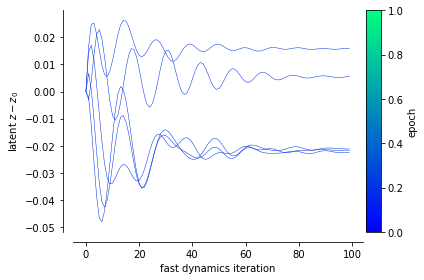

In [4]:
with dv.FigureManager() as (_, ax):
    cmap = mpl.cm.winter
    crt_sel = (trainer.history.fast["sample"] == batch_size - 1) & (
        trainer.history.fast["epoch"] < 80
    )

    crt_epoch = trainer.history.fast["epoch"][crt_sel]
    crt_z = trainer.history.fast["z:1"][crt_sel]

    n = len(crt_epoch)
    for i in range(n):
        color = cmap(int(cmap.N * (0.2 + 0.8 * i / n)))
        ax.plot(crt_z[i, :, :] - crt_z[i, 0, :], c=color, lw=0.5)

    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.pyplot.Normalize(vmin=0, vmax=n))
    sm.ax = ax
    cbar = dv.colorbar(sm)
    cbar.set_label("epoch")

    ax.set_xlabel("fast dynamics iteration")
    ax.set_ylabel("latent $z - z_0$")

 ## Check whitening constraint in hidden layer

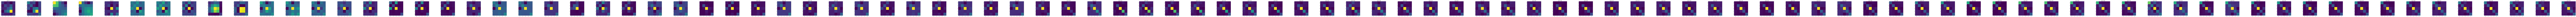

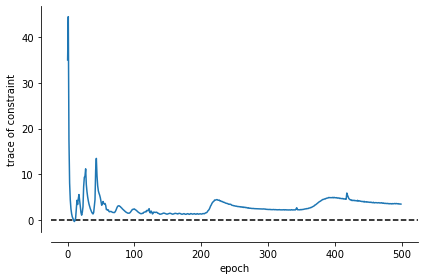

In [5]:
hidden_size = net.pyr_dims[1]
z_cov = torch.zeros((n_epochs, hidden_size, hidden_size))
for epoch in range(n_epochs):
    crt_sel = trainer.history.latent["epoch"] == epoch
    crt_z = trainer.history.latent["z:1"][crt_sel]

    z_cov[epoch] = crt_z.T @ crt_z / len(crt_z)

tr_cons = [torch.trace(z_cov[i] - torch.eye(hidden_size)) for i in range(n_epochs)]
sel_epochs = [_ for _ in range(4, n_epochs, 5)]
with dv.FigureManager(1, len(sel_epochs), do_despine=False) as (_, axs):
    for ax, epoch in zip(axs, sel_epochs):
        ax.imshow(z_cov[epoch])
        ax.set_title(f"epoch {epoch}")

with dv.FigureManager() as (_, ax):
    ax.axhline(0, c="k", ls="--")
    ax.plot(tr_cons)
    ax.set_xlabel("epoch")
    ax.set_ylabel("trace of constraint")

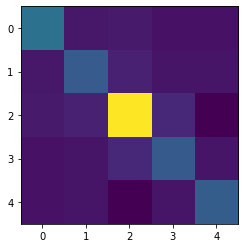

In [6]:
mpl.pyplot.imshow(z_cov[-1])

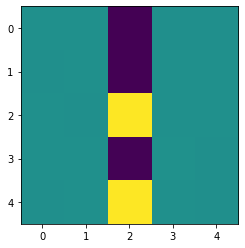

In [7]:
mpl.pyplot.imshow(trainer.history.weight["Q:0"][-1])

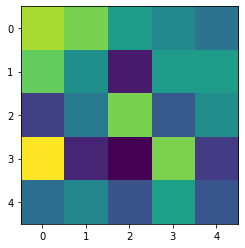

In [8]:
mpl.pyplot.imshow(trainer.history.weight["Q:0"][0])

In [9]:
trainer.history.latent["z:1"][-1]

tensor([ 0.1074, -1.3735, -2.0211, -0.2581,  0.7857])

In [10]:
trainer.history.latent["n:1"][-1]

KeyError: 'n:1'

In [11]:
trainer.history.latent["n:0"][-1]

KeyError: 'n:0'

In [12]:
trainer.history.latent["z:1"][-1] @ trainer.history.weight["Q:0"].T

<ipython-input-12-544276e1eb7f>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  trainer.history.latent["z:1"][-1] @ trainer.history.weight["Q:0"].T


tensor([[ 0.1187, -0.0974, -0.2106,  ...,  0.2327,  0.2254,  0.2242],
        [ 0.3916,  0.6426,  0.8118,  ...,  0.6654,  0.6539,  0.6559],
        [-0.0795,  0.0828,  0.1815,  ...,  7.7974,  7.8122,  7.8272],
        [ 0.4821,  0.6370,  0.7217,  ...,  0.1939,  0.1870,  0.1971],
        [-0.2059, -0.1950, -0.2689,  ..., -0.0904, -0.0743, -0.0787]])

In [13]:
trainer.history.latent["z:1"][-1] @ trainer.history.weight["Q:0"][-1].T

tensor([ 55.4180,  55.2491, -54.8006,  55.0997, -55.2537])

In [14]:
trainer.history.latent["z:1"][-1]

tensor([ 0.1074, -1.3735, -2.0211, -0.2581,  0.7857])

In [15]:
trainer.history.latent["z:1"][-1] @ trainer.history.weight["Q:0"][-1].T @ trainer.history.weight["Q:0"][-1]

tensor([ 3.7266e+00,  2.2642e+00, -7.5301e+03, -4.4746e+00, -2.8293e+00])

In [16]:
net.h_a[0]

tensor([-27.9110,  27.2728,  27.3676, -28.1709, -27.2071, -27.3012, -27.4998,
         27.4065, -27.2936, -27.2401], requires_grad=True)

In [17]:
net.h_b[0]

tensor([-0.2016,  0.0613,  0.2104, -0.0255,  0.0530], requires_grad=True)

 # Diagnosing CPCN

In [1]:
from types import SimpleNamespace
import pydove as dv
import matplotlib as mpl

import torch

from tqdm.notebook import tqdm

from cpcn import LinearCPCNetwork, load_mnist, Trainer

 ## Setup

In [2]:
device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# this creates the loaders
batch_size = 100
dataset = load_mnist(
    n_train=5000, n_validation=1000, batch_size=batch_size, device=device
)

 ## Train CPCN

In [3]:
n_epochs = 500
dims = [784, 5, 10]

z_it = 100
z_lr = 0.02

torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * torch.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * torch.ones(len(dims) - 2)
g_b[0] *= 2

net = LinearCPCNetwork(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    fast_optimizer=torch.optim.Adam,
    bias_a=False,
    bias_b=False,
)
net = net.to(device)

trainer = Trainer(net, dataset["train"], dataset["validation"])
trainer.set_classifier("linear")

trainer.peek_epoch("weight", ["W_a", "W_b", "Q", "M"])
trainer.peek_sample("latent", ["z"])
trainer.peek_fast_dynamics(
    "fast",
    ["a", "b", "z", "n"],
    condition=lambda epoch, batch: epoch % 50 == 49 and batch == 49,
)

results = trainer.run(n_epochs, progress=tqdm)

  0%|          | 0/500 [00:00<?, ?it/s]

 ## Check convergence of latent variables

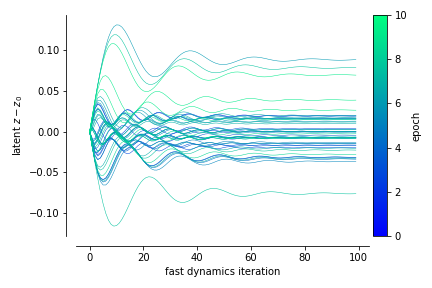

In [4]:
with dv.FigureManager() as (_, ax):
    cmap = mpl.cm.winter
    crt_sel = trainer.history.fast["sample"] == batch_size - 1

    crt_epoch = trainer.history.fast["epoch"][crt_sel]
    crt_z = trainer.history.fast["z:1"][crt_sel]

    n = len(crt_epoch)
    for i in range(n):
        color = cmap(int(cmap.N * (0.2 + 0.8 * i / n)))
        ax.plot(crt_z[i, :, :] - crt_z[i, 0, :], c=color, lw=0.5)

    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.pyplot.Normalize(vmin=0, vmax=n))
    sm.ax = ax
    cbar = dv.colorbar(sm)
    cbar.set_label("epoch")

    ax.set_xlabel("fast dynamics iteration")
    ax.set_ylabel("latent $z - z_0$")

 ## Check whitening constraint in hidden layer

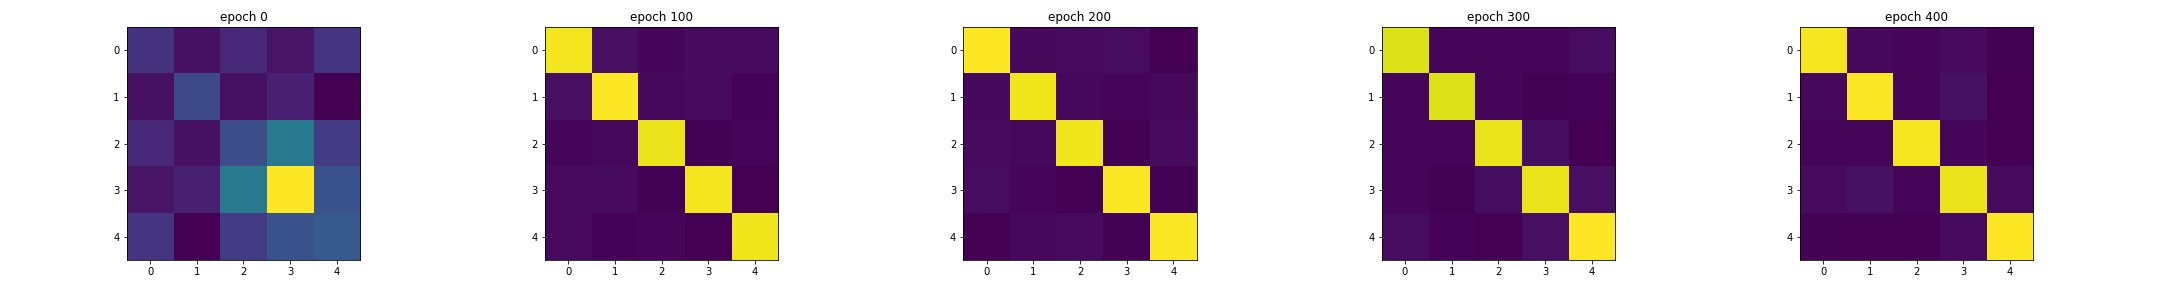

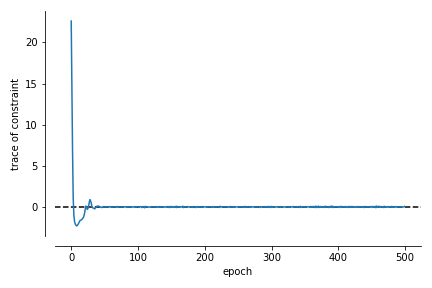

In [5]:
hidden_size = net.pyr_dims[1]
z_cov = torch.zeros((n_epochs, hidden_size, hidden_size))
for epoch in range(n_epochs):
    crt_sel = trainer.history.latent["epoch"] == epoch
    crt_z = trainer.history.latent["z:1"][crt_sel]

    z_cov[epoch] = crt_z.T @ crt_z / len(crt_z)

tr_cons = [torch.trace(z_cov[i] - torch.eye(hidden_size)) for i in range(n_epochs)]
sel_epochs = list(range(0, n_epochs, int(n_epochs / 5)))
with dv.FigureManager(1, len(sel_epochs), do_despine=False) as (_, axs):
    for ax, epoch in zip(axs, sel_epochs):
        ax.imshow(z_cov[epoch])
        ax.set_title(f"epoch {epoch}")

with dv.FigureManager() as (_, ax):
    ax.axhline(0, c="k", ls="--")
    ax.plot(tr_cons)
    ax.set_xlabel("epoch")
    ax.set_ylabel("trace of constraint")

 ## Show loss and accuracy evolution

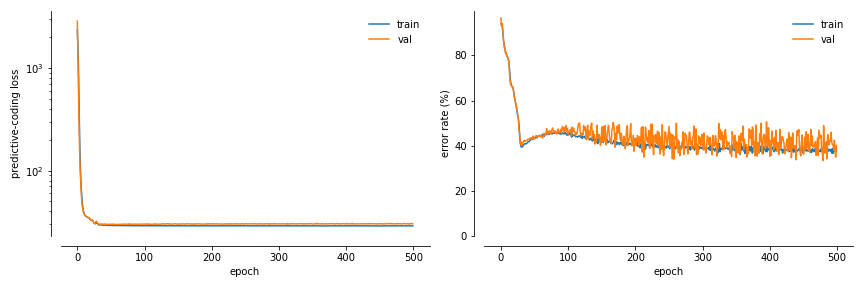

In [11]:
with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.plot(results.train.pc_loss, label="train")
    ax1.plot(results.validation.pc_loss, label="val")
    ax1.legend(frameon=False)
    ax1.set_yscale("log")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("predictive-coding loss")

    ax2.plot(100 * (1.0 - results.train.accuracy), label="train")
    ax2.plot(100 * (1.0 - results.validation.accuracy), label="val")
    ax2.legend(frameon=False)
    ax2.set_ylim(0, None)
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("error rate (%)")